## Deep Q-Learning and Variants in Gym's Lunar Lander Environment

In this notebook, we will explore the implementation of a Deep Q-Learning (DQN) agent to navigate Gym's Lunar Lander environment.

We will use apply four variants of the DQN algorithm:
- The Classic DQN (Mihn et al 2013)
- Double DQN (Hasselt et al 2015)
- Dueling DQN (Wang et al 2015)

In the Lunar Lander environment, the agent's task is to learn how to land a lunar module safely on the moon's surface. This requires the agent to balance fuel efficiency and safety considerations. The agent needs to learn from its past experiences, developing a strategy to approach the landing pad while minimizing its speed and using as little fuel as possible.

All reinforcement learning (RL) methods will be built from scratch, providing a comprehensive understanding of their workings.

Let's initialize a LunarLander-v2 environmnet, make random actions in the environment, then view a recording of it.

OpenAI Gym provides a collection of environments (like LunarLander-v2) that can be used to test and train RL agents

In [ ]:
!pip install swig
!pip install gym[box2d]

In [ ]:
import gym

env = gym.make('LunarLander-v2', new_step_api=True)

'''The seed parameter initializes the random number generator used by the environment.
By setting the seed (in this case, 42), you ensure that the environment will be the same every time you run the code.'''
env.reset(seed=42)


# Play one complete episode with random actions
while True:
  '''The new observation (state) after taking the action (_ is used to ignore it here).
     The reward received for the action (_ is ignored).
     terminated: If the episode has ended because the agent has reached a terminal state (like crashing or successfully landing).
     truncated: If the episode has been truncated, meaning it was ended because it reached the maximum number of steps allowed.
     Additional information about the environment (_ is ignored).'''
    action = env.action_space.sample()
    _, _, terminated, truncated, _ = env.step(action)
    if terminated or truncated:
        break

env.close()


![](https://i.imgur.com/tQ3zeQA.gif)

## General Information
This information is from the official Gym documentation.

https://www.gymlibrary.dev/environments/box2d/lunar_lander/

| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(4)                            |
| Observation Shape | (8,)                                   |
| Observation High  | [1.5 1.5 5. 5. 3.14 5. 1. 1. ]         |
| Observation Low   | [-1.5 -1.5 -5. -5. -3.14 -5. -0. -0. ] |
| Import            | `gym.make("LunarLander-v2")`           |

## Description of Environment

This environment is a classic rocket trajectory optimization problem. According to Pontryagin’s maximum principle, it is optimal to fire the engine at full throttle or turn it off. This is the reason why this environment has discrete actions: engine on or off.

There are two environment versions: discrete or continuous. The landing pad is always at coordinates `(0,0)`. The coordinates are the first two numbers in the state vector. Landing outside of the landing pad is possible. Fuel is infinite, so an agent could learn to fly and then land on its first attempt.

## Action Space
There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

| Action  | Result                          |
|---------|---------------------------------|
| 0       | Do nothing                      |
| 1       | Fire left orientation engine    |
| 2       | Fire main engine                |
| 3       | Fire right orientation engine   |

## Observation Space
The state is an 8-dimensional vector: the coordinates of the lander in `x` & `y`, its linear velocities in `x` & `y`, its angle, its angular velocity, and two booleans that represent whether each leg is in contact with the ground or not.

| Observation  | Value                                   |
|--------------|-----------------------------------------|
| 0            | `x` coordinate (float)                  |
| 1            | `y` coordinate (float)                  |
| 2            | `x` linear velocity (float)             |
| 3            | `y` linear velocity (float)             |
| 4            | Angle in radians from -π to +π (float)  |
| 5            | Angular velocity (float)                |
| 6            | Left leg contact (bool)                 |
| 7            | Right leg contact (bool)                |

## Rewards
Reward for moving from the top of the screen to the landing pad and coming to rest is about 100-140 points. If the lander moves away from the landing pad, it loses reward. If the lander crashes, it receives an additional -100 points. If it comes to rest, it receives an additional +100 points. Each leg with ground contact is +10 points. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solved is 200 points.

1) **Reward for Moving to the Landing Pad (100-140 points)**

When the lander successfully moves from the top of the screen to the landing pad and comes to rest, it earns a reward in the range of 100 to 140 points.

The exact reward within this range depends on factors like how smoothly the lander lands and how close it is to the center of the landing pad.

2) **Penalty for Moving Away from the Landing Pad**

If the lander moves away from the landing pad it losses 100 points.(-100 points)

3) **If the lander crashes**

for example, by hitting the ground too hard or landing at a steep angle4), it receives a penalty of -100 points.

4) **Bonus for Coming to Rest (+100 points)**

If the lander successfully lands and comes to a complete stop it receives an additional reward of +100 points.

5) **Leg Contact Bonus (+10 points per leg)**

For each leg of the lander that makes contact with the ground, the agent receives +10 points.

Since the lander has two legs, it can earn up to 20 points if both legs touch down properly.

6) **Engine Firing Costs (Main Engine: -0.3 points per frame, Side Engine: -0.03 points per frame)**

Every time the main engine is fired, the agent loses 0.3 points per frame
Every time a side engine is fired, the agent loses 0.03 points per frame.

This penalty discourages excessive use of fuel and encourages efficient control of the lander

7) **"Solved" Condition (200 points)**

The task is considered "solved" if the agent achieves a score of 200 points or more.

**Reaching this score indicates that the agent has learned to land the Lunar Lander effectively and efficiently.**

## Starting State
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

## Episode Termination
The episode finishes if:

1. The lander crashes (the lander body gets in contact with the moon);

2. The lander gets outside of the viewport (`x` coordinate is greater than 1);

3. The lander is not awake. From the Box2D docs, a body which is not awake is a body which doesn’t move and doesn’t collide with any other body:

*   "not awake" body is one that has stopped moving and is not interacting with any other object
*   if the lander comes to a complete stop (no longer moving and not at risk of further collisions), the episode will terminate



---

## The Safe Agent
We're going to implement a simple agent 'The Safe Agent' who will thrust upward if and only if the lander's `y` position is less than 0.5.

In theory this agent shouldn't hit the ground as we have unlimited fuel, but let's see.

OpenAI Gym provides a collection of environments (like LunarLander-v2) that can be used to test and train RL agents



In [ ]:
import gym

class SafeAgent:
    '''
    An agent that will simply fly upward if the lander gets too close to the ground.
    '''    def act(self, state):
        '''
        Decision making method.
        Fly up if below the minimum height.
        '''
        MIN_HEIGHT = 1

        if state[1] < MIN_HEIGHT:
          '''
          return 2: This action corresponds to firing the main engine, generally to fly upwards.

          return 0: This action corresponds to doing nothing, where no engines are fired, and the lander continues with its current state.
          '''
            return 2
        else:
            return 0


def play_episode(env, agent, seed=42):
    '''
    Plays a full episode for a given agent, environment and seed.
    '''
    score = 0
    state = env.reset(seed=seed)  # Unpack only the state

    while True:
        action = agent.act(state)
        state, reward, done, info = env.step(action)  # Unpack 4 values
        score += reward

        # End the episode if done
        if done:
            break

    return score  # Return the score for potential future use


env = gym.make('LunarLander-v2')
agent = SafeAgent()

play_episode(env, agent)


-260.82660246093013


* The score indicates that the SafeAgent is not performing well and requires adjustments to improve its performance in the LunarLander-v2 environment.

* The SafeAgent only makes decisions based on vertical height and doesn’t utilize the side engines, which are crucial for controlling horizontal movement.
*It quickly moved off the screen because it didn’t use the side engines to control its lateral movement.

![](https://i.imgur.com/qFNn9ai.gif)

#### Observations:
- The safe agent may not have hit the ground, but it didn't take long to fly off screen, due to its inability to use the side engines.

---

## The Stable Agent
Let's try to define and agent that can remain stable in the air.

It will operate via the following rules:

1. If below height of 1: action = 2 (main engine)
2. If angle is above π/50: action = 1 (fire right engine)
3. If angle is above π/50: action = 1 (fire left engine)
4. If x distance is above 0.4: action = 3 (fire left engine)
5. If x distance is below -0.4: action = 1 (fire left engine)
6. If below height of 1.5: action = 2 (main engine)
6. Else: action = 0 (do nothing)

The idea is the lander will always use its main engine if it falls below a certain height, next it will prioritize stabilizing the angle of the lander, then the distance, then keeping it above another height.

Let's see how this approach does:

In [ ]:
class StableAgent:
    '''
    An agent that attempts to fly the lander stably using a set of inflexible rules.
    '''
    def act(self, state):
        '''
        Decision making method.
        Fly according to the rules described above.
        '''
        # Decision making thresholds
        UPPER_MIN_Y = 1.5
        LOWER_MIN_Y = 1
        MIN_X = -0.4
        MAX_X = 0.4
        MIN_ANGLE = -3.14/50
        MAX_ANGLE = 3.14/50

        # Convenient forms for angle, x and y coordinates
        x = state[0]
        y = state[1]
        angle = state[4]

        # Actions corresponding to firing the main, left, or right engines, or doing nothing.
        MAIN_ENGINE = 2
        LEFT_ENGINE = 1
        RIGHT_ENGINE = 3
        DO_NOTHING = 0

        # If very low, be sure to use main engine
        if y < LOWER_MIN_Y:
            return MAIN_ENGINE

        # Try to keep angle within a small range (If the lander’s angle is too tilted, the appropriate side engine is fired to correct it.)
        elif angle > MAX_ANGLE:
            return RIGHT_ENGINE
        elif angle < MIN_ANGLE:
            return LEFT_ENGINE

        # If the lander too far left or right, the corresponding side engine is fired to bring it back to the center.
        elif x > MAX_X:
            return LEFT_ENGINE
        elif x < MIN_X:
            return RIGHT_ENGINE

        # If lander is stable, use main engine to maintain height
        elif y < UPPER_MIN_Y:
            return MAIN_ENGINE

        # If the lander is within the acceptable ranges for height, angle, and horizontal position, the agent does nothing.
        else:
            return DO_NOTHING


env = gym.make('LunarLander-v2')
agent = StableAgent()

play_episode(env, agent)

-404.82909858960977

* Overuse of Engines: The agent might have fired the engines too often, incurring penalties with each frame (main engine: -0.3 points per frame; side engines: -0.03 points per frame).

* Failure to Land: The agent may not have managed to land successfully or may have drifted off-screen, resulting in further penalties.

* Instability: Despite being designed to stabilize the lander.

![](https://i.imgur.com/Bdq1Hdl.gif)

#### Observations:
- Crafting a straightforward set of rules to guide the lunar lander is more challenging than anticipated.
- Our initial efforts achieved some stability, but eventually, the lander lost control.

---

# Deep Reinforcement Learning
To address this challenge, we'll use deep reinforcement learning techniques to train an agent to land the spacecraft.

Simpler tabular methods are limited to discrete observation spaces, meaning there are a finite number of possible states. In `LunarLander-v2` however, we're dealing with a continuous range of states across 8 different parameters, meaning there are a near-infinite number of possible states. We could try to bin similar values into groups, but due to the sensitive controls of the game, even slight errors can lead to significant missteps.

To get around this, we'll use a `neural network Q-function approximator`. This lets us predict the best actions to take for a given state, even when dealing with a vast number of potential states. It's a much better match for our complex landing challenge.

## The DQN Algorithm:

This breakthrough algorithm was used by Mihn et al in 2015 to achieve human-level performance on several Atari 2600 games.

The original paper published in Nature can be viewed here:

https://www.deepmind.com/publications/human-level-control-through-deep-reinforcement-learning

The algorithm:

1. **Initialization**: Begin by initializing the parameters for two neural networks, $Q(s,a)$ (referred to as the online network) and $\hat{Q}(s,a)$ (known as the target network), with random weights. Both networks serve the function of mapping a state-action pair to a Q-value, which is an estimate of the expected return from that pair. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer to store past transition experiences.
2. **Action Selection**: Utilize an epsilon-greedy strategy for action selection. With a probability of $\epsilon$, select a random action $a$, but in all other instances, choose the action $a$ that maximizes the Q-value, i.e., $a = argmax_aQ(s,a)$.
3. **Experience Collection**: Execute the chosen action $a$ within the environment emulator and observe the resulting immediate reward $r$ and the next state $s'$.
4. **Experience Storage**: Store the transition $(s,a,r,s')$ in the replay buffer for future reference.
5. **Sampling**: Randomly sample a mini-batch of transitions from the replay buffer for training the online network.
6. **Target Computation**: For every transition in the sampled mini-batch, compute the target value $y$. If the episode has ended at this step, $y$ is simply the reward $r$. Otherwise, $y$ is the sum of the reward and the discounted estimated optimal future Q-value, i.e.,  $y = r + \gamma \max_{a' \in A} \hat{Q}(s', a')$
7. **Loss Calculation**: Compute the loss, which is the squared difference between the Q-value predicted by the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$
8. **Online Network Update**: Update the parameters of the online network $Q(s,a)$ using Stochastic Gradient Descent (SGD) to minimize the loss.
9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network to the target network $\hat{Q}(s,a)$.
10. **Iterate**: Repeat the process from step 2 until convergence.

### Defining the Deep Q-Network
Our network will be a simple feedforward neural network that takes the state as input and produces Q-values for each action as output. For `LunarLander-v2` the state is an 8-dimensional vector and there are 4 possible actions.


In [ ]:
import torch

class DQN(torch.nn.Module):
    '''
    This defines the architecture of a neural network that will be used to approximate the Q-values in a reinforcement learning environment.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.

    Parameters
    ----------
    state_size: int, default=8 (Environment’s state is represented by 8 variables.)
        The size of the state space.
    action_size: int, default=4 (There are 4 possible actions.)
        The size of the action space.
    hidden_size: int, default=64 (This is a hyperparameter that can be tuned based on performance.)
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.

        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

### Defining the Replay Buffer
In the context of RL, we employ a structure known as the replay buffer, which utilizes a deque. The replay buffer stores and samples experiences, which helps us overcome the problem of *step correlation*.

A *deque* (double-ended queue) is a data structure that enables the addition or removal of elements from both its ends, hence the name. It is particularly useful when there is a need for fast append and pop operations from either end of the container, which it provides at O(1) time complexity. In contrast, a list offers these operations at O(n) time complexity, making the deque a preferred choice in cases that necessitate more efficient operations.

Moreover, a deque allows setting a maximum size. Once this maximum size is exceeded during an insertion (push) operation at the front, the deque automatically ejects the item at the rear, thereby maintaining its maximum length.

In the replay buffer, the `push` method is utilized to add an experience. If adding this experience exceeds the maximum buffer size, the oldest (rear-most) experience is automatically removed. This approach ensures that the replay buffer always contains the most recent experiences up to its capacity.

The `sample` method, on the other hand, is used to retrieve a random batch of experiences from the replay buffer. This randomness is critical in breaking correlations within the sequence of experiences, which leads to more robust learning.

This combination of recency and randomness allows us to learn on new training data, without training samples being highly correlated.

In [ ]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.

The replay buffer allows the agent to store past experiences
(tuples of state, action, reward, next state, and done flag) and then sample from this collection of experiences at random to train the neural network.

    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        The experience is appended to the buffer, which automatically handles capacity by discarding the oldest experience if the buffer is full.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)

### Define the DQN Agent
The DQN agent handles the interaction with the environment, selecting actions, collecting experiences, storing them in the replay buffer, and using these experiences to train the network. Let's walk through each part of this process:

The DQNAgent class, It leverages a replay buffer for experience replay, a Q-Network for estimating Q-values, and a Target Network to stabilize training.

The agent uses an epsilon-greedy policy for action selection. The periodic update of the Target Network helps in making the learning process more stable by reducing oscillations and divergence in Q-value estimation.


#### Initialisation
The `__init__` function sets up the agent:

- `self.device`: We start by checking whether a GPU is available, and, if so, we use it, otherwise, we fall back to CPU.
- `self.gamma`: This is the discount factor for future rewards, used in the Q-value update equation.
- `self.batch_size`: This is the number of experiences we'll sample from the memory when updating the model.
- `self.q_network` and `self.target_network`: These are two instances of the Q-Network. The first is the network we're actively training, and the second is a copy that gets updated less frequently. This helps to stabilize learning.
- `self.optimizer`: This is the optimization algorithm used to update the Q-Network's parameters.
- `self.memory`: This is a replay buffer that stores experiences. It's an instance of the `ReplayBuffer` class.

#### Step Function
The `step` function is called after each timestep in the environment:

- The function starts by storing the new experience in the replay buffer.
- If enough experiences have been stored, it calls `self.update_model()`, which triggers a learning update.

#### Action Selection
The act function is how the agent selects an action:

- If a randomly drawn number is greater than $\epsilon$, it selects the action with the highest predicted Q-value. This is known as exploitation: the agent uses what it has learned to select the best action.
- If the random number is less than $\epsilon$, it selects an action randomly. This is known as exploration: the agent explores the environment to learn more about it.

#### Model Update
The `update_model` function is where the learning happens:

- It starts by sampling a batch of experiences from the replay buffer.
- It then calculates the current Q-values for the sampled states and actions, and the expected - Q-values based on the rewards and next states.
- It calculates the loss, which is the mean squared difference between the current and expected Q-values.
- It then backpropagates this loss through the Q-Network and updates the weights using the optimizer.

#### Target Network Update
Finally, the `update_target_network` function copies the weights from the Q-Network to the Target Network. This is done periodically (not every step), to stabilize the learning process. Without this, the Q-Network would be trying to follow a moving target, since it's learning from estimates produced by itself.

In [ ]:
class DQNAgent:
    '''
    That uses a Deep Q-Network (DQN) and a replay memory to interact with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=8, action_size=4, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device

        '''The main network used to approximate Q-values.'''
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)

        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters

        '''An Adam optimizer is used to update the Q-Network’s parameters.'''
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Initialize the replay memory

        '''Stores past experiences to be sampled for training.'''
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
       step -  Records an experience in the replay buffer and, if enough experiences have been gathered, updates the Q-network by sampling from the buffer.'''
        ----------
      '''  state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)

        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state using epsilon-greedy policy.
        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps

        '''epsilon-greedy policy - If a random number is greater than eps, the agent uses the Q-Network to predict the best action.'''

        if random.random() > eps:
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        '''
        Updates the Q-Network by learning from a batch of experiences sampled from the replay buffer.'''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        '''The Q-values for the actions taken are calculated using the Q-Network.'''
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()

        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        ''' The loss between the predicted Q-values and the expected Q-values is calculated using Mean Squared Error (MSE).'''
        loss = torch.nn.MSELoss()(q_values, expected_q_values)

        # Zero all gradients
        self.optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

### Training the Agent

Training the agent involves having the agent interact with the `LunarLander-v2` environment over a sequence of steps. Over each step, the agent receives a state from the environment, selects an action, receives a reward and the next state, and then updates its understanding of the environment (the Q-table in the case of Q-Learning).

The `train` function orchestrates this process over a defined number of episodes, using the methods defined in the DQNAgent class. Here's how it works:

#### Initial Setup
- `scores`: This list stores the total reward obtained in each episode.
- `scores_window`: This is a double-ended queue with a maximum length of 100. It holds the scores of the most recent 100 episodes and is used to monitor the agent's performance.
-`eps`: This is the epsilon for epsilon-greedy action selection. It starts from `eps_start` and decays after each episode until it reaches `eps_end`.

#### Episode Loop
The training process runs over a fixed number of episodes. In each episode:

- The environment is reset to its initial state.
- he agent then interacts with the environment until the episode is done (when a terminal state is reached).

#### Step Loop
In each step of an episode:

- The agent selects an action using the current policy (the act method in `DQNAgent`).
The selected action is applied to the environment using the step method, which returns the next state, the reward, and a boolean indicating whether the episode is done.
- The agent's step method is called to update the agent's knowledge. This involves adding the experience to the replay buffer and, if enough experiences have been collected, triggering a learning update.
- The state is updated to the next state, and the reward is added to the score.

After each episode:

- The score for the episode is added to `scores` and `scores_window`.
- Epsilon is decayed according to `eps_decay`.
- If the episode is a multiple of `target_update`, the target network is updated with the latest weights from the Q-Network.
- Finally, every 100 episodes, the average score over the last 100 episodes is printed.

The function returns the list of scores for all episodes.

This training process, which combines experiences from the replay buffer and separate target and Q networks, helps to stabilize the learning and leads to a more robust policy.

In [ ]:
import gym
import numpy as np
from collections import deque

# Define the DQNAgent class according to your implementation

def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    '''
    Train a DQN agent.

    Parameters
    ----------
    agent: DQNAgent
        The DQN agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        Total number of episodes for training.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        Rate at which epsilon decays.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.

    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):

        # Reset environment and score at the start of each episode
        state = env.reset()  # Unpack only the state
        score = 0

        # Loop over steps
        while True:

            # Select an action using current agent policy then apply in environment
            '''Chooses an action based on the epsilon-greedy policy.'''

            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)  # Unpack 4 values

            # Update the agent, state, and score
            '''Updates the agent with the new experience and performs learning.'''
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of the episode, append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        '''Updates the target network periodically.'''
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        # This environment is considered to be solved for a mean score of 200 or greater, so stop training.
        '''Stops training if the average score over the last 100 episodes reaches or exceeds 200.'''
        '''The output logs the average score for every 100 episodes.'''
        if i_episode % 100 == 0 and np.mean(scores_window) >= 200:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            break

    return scores


# Make an environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize a DQN agent
agent = DQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -129.04
Episode 200	Average Score: -69.05
Episode 300	Average Score: -10.17
Episode 400	Average Score: 82.49
Episode 500	Average Score: 110.11
Episode 600	Average Score: 157.07
Episode 700	Average Score: 135.08
Episode 800	Average Score: 144.62
Episode 900	Average Score: 61.95
Episode 1000	Average Score: 118.87
Episode 1100	Average Score: 128.77
Episode 1200	Average Score: 174.79
Episode 1300	Average Score: 211.66

Environment solved in 1300 episodes!	Average Score: 211.66


Observations:

* The agent's average score steadily improves, indicating that the agent is learning and performing better over time.


**You will get below answers when you run the code:** (When you run the code there can be sightly changes happen with these answers)



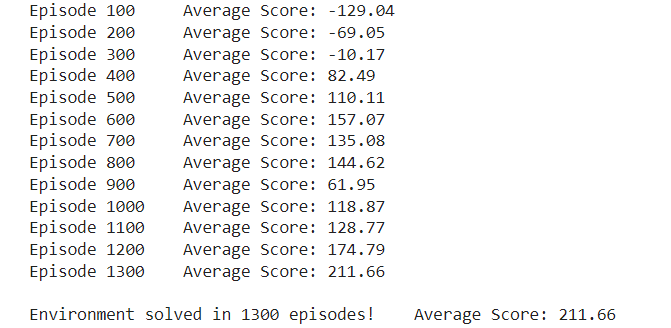

#### Observations:
- Our DQN agent is able to solve the game typically after playing around 1200 episodes.
- Let's watch a video of this agent's performance:

In [ ]:
def play_DQN_episode(env, agent):
    score = 0
    state = env.reset(seed=42)  # Reset the environment and get the initial state

    while True:
        # eps=0 for predictions
        action = agent.act(state, 0)
        next_state, reward, terminated, truncated = env.step(action)  # Unpack 4 values
        done = terminated or truncated

        score += reward
        state = next_state  # Move to the next state

        # End the episode if done
        if done:
            break

    return score

score = play_DQN_episode(env, agent)
print("Score obtained:", score)


Score obtained: 253.6576198694293


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Answer:

Score obtained: 253.6576198694293


**Resons for the improvement:**

* Experience Accumulation: The agent gathers useful experiences over time, helping it learn better.

* Epsilon Decay: As exploration decreases (epsilon decays), the agent exploits its learned knowledge more effectively.

* Learning from Past Experiences: The agent revisits and learns from past actions stored in the replay buffer.

* Target Network Stability: Periodic updates to the target network provide stable learning targets, improving consistency.

![](https://i.imgur.com/NAg48Qk.gif)

## Double DQN (DDQN)
The Double Deep Q-Network (DDQN) algorithm is a modification of the standard Deep Q-Network (DQN) algorithm, which reduces the overestimation bias in the Q-values, thereby improving the stability of the learning process. You can read the original publication by Hasselt et al from late 2015 here:

https://arxiv.org/abs/1509.06461

### The DDQN Algorithm

1. **Initialization**: Similar to DQN, initialize the parameters of two neural networks, $Q(s,a)$ (online network) and $\hat{Q}(s,a)$ (target network), with random weights. Both networks estimate Q-values from state-action pairs. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer.

2. **Action Selection**: Use an epsilon-greedy strategy, just like in DQN. With a probability of $\epsilon$, select a random action $a$, otherwise, select the action $a$ that yields the highest Q-value, i.e., $a = argmax_aQ(s,a)$.

3. **Experience Collection**: Carry out the selected action $a$ in the environment to get the immediate reward $r$ and the next state $s'$.

4. **Experience Storage**: Store the transition tuple $(s,a,r,s')$ in the replay buffer.

5. **Sampling:** Randomly sample a mini-batch of transitions from the replay buffer.

6. **Target Computation**: Here comes the primary difference from DQN. For every transition in the sampled mini-batch, compute the target value $y$. If the episode has ended, $y = r$. Otherwise, unlike DQN that uses the max operator to select the action from the target network, DDQN uses the online network to select the best action, and uses its Q-value estimate from the target network, i.e., $y = r + \gamma \hat{Q}(s', argmax_{a' \in A} Q(s', a'))$. This double estimator approach helps to reduce overoptimistic value estimates.

7. **Loss Calculation**: Compute the loss as the squared difference between the predicted Q-value from the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$.

8. **Online Network Update**: Perform Stochastic Gradient Descent (SGD) on the online network to minimize the loss.

9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network.

10. **Iterate**: Repeat the process from step 2 until convergence.

In summary, the key difference in DDQN lies in the way the target Q-value is calculated for non-terminal states during the update. DDQN chooses the action using the online network and estimates the Q-value for this action using the target network. This modification helps mitigate the issue of overestimation present in standard DQN.


# Differences of DQN and DDQN agents

| DQN agent                       | DDQN agent                                 |
|-------------------              |----------------------------------------    |
|Uses the target network to select and evaluate the best action for the next state. | Uses the online network to select the best action, but uses the target network to evaluate that action.
|Prone to overestimating Q-values because the same network is used for both selecting and evaluating actions. | Reduces overestimation bias by decoupling the action selection and evaluation processes.
|Simpler to implement; uses one step to get the maximum Q-value from the target network.| Slightly more complex; requires two steps—one for action selection using the online network and another for evaluation using the target network.
|Can lead to unstable learning and suboptimal policies due to overestimation|Provides more stable learning, leading to better long-term performance.
|Suitable for simpler tasks or when you want a quick implementation.|Preferred for more complex tasks where reducing overestimation is crucial for learning stability.










In [ ]:
class DDQNAgent:
    def __init__(self, state_size=8, action_size=4, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get the action values from the online network
        next_action_values = self.q_network(next_states).max(1)[1].unsqueeze(-1)

        # Get the Q-values from the target network for the actions chosen by the Q-network
        next_q_values = self.target_network(next_states).gather(1, next_action_values).detach().squeeze(-1)

        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)

        # Zero all gradients
        self.optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DDQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

# Play a demonstration episode
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 100	Average Score: -135.93
Episode 200	Average Score: -66.04
Episode 300	Average Score: -38.91
Episode 400	Average Score: 70.30
Episode 500	Average Score: 137.27
Episode 600	Average Score: 196.21
Episode 700	Average Score: 178.76
Episode 800	Average Score: 166.98
Episode 900	Average Score: 199.25
Episode 1000	Average Score: 151.15
Episode 1100	Average Score: 229.83

Environment solved in 1100 episodes!	Average Score: 229.83
Score obtained: 219.28302494053798



**You will get below answers when you run the code:**(When you run the code there can be sightly changes happen with these answers)


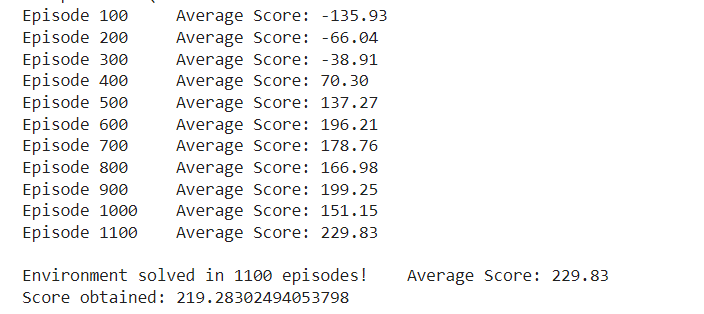

**Resons for the improvement:**
* Solved the environment 200 episodes earlier than the DQN.
* Achieved a higher average score in the end, indicating better performance than DQN.

* The Double DQN agent performed better, reaching a solution faster and with more stability,

![](https://i.imgur.com/rrfB9Vl.gif)

## Dueling Deep Q-Networks (Dueling DQN)
The Dueling Deep Q-Network (Dueling DQN) algorithm is an extension of the standard Deep Q-Network (DQN) algorithm, which aims to improve the estimation of the state-value function and thus enhance the quality of the policy. The dueling architecture was proposed by Wang et al in 2015, and you can find their original paper here:

https://arxiv.org/abs/1511.06581

### The Dueling DQN Algorithm
1. **Initializatin**: In Dueling DQN, initialize the parameters of two neural networks, $Q(s,a)$ (online network) and $\hat{Q}(s,a)$ (target network), with random weights. Unlike the traditional DQN, each network in Dueling DQN splits into two separate streams at some point - one for estimating the state-value function $V(s)$ and the other for estimating the advantage function $A(s,a)$. Also, set the exploration probability $\epsilon$ to 1.0, and create an empty replay buffer.

2. **Action Selection**: The action selection process is the same as DQN. Use an epsilon-greedy strategy. With a probability of $\epsilon$, select a random action $a$, otherwise, select the action $a$ that yields the highest Q-value, i.e., $a = argmax_aQ(s,a)$.

3. **Experience Collection**: Carry out the selected action $a$ in the environment to obtain the immediate reward $r$ and the next state $s'$.

4. **Experience Storage**: Store the transition tuple $(s,a,r,s')$ in the replay buffer.

5. **Sampling**: Randomly sample a mini-batch of transitions from the replay buffer.

6. **Target Computation**: For each transition in the sampled mini-batch, compute the target value $y$. If the episode has ended, $y = r$. Otherwise, compute $y$ as $y = r + \gamma \hat{Q}(s', argmax_{a' \in A} Q(s', a'))$.

7. **Loss Calculation**: Compute the loss as the squared difference between the predicted Q-value from the online network and the computed target, i.e., $\mathcal{L} = (Q(s,a) - y)^2$.

8. **Online Network Update**: Use Stochastic Gradient Descent (SGD) or another optimization algorithm to update the online network and minimize the loss.

9. **Target Network Update**: Every $N$ steps, update the target network by copying the weights from the online network.

10. **Iterate**: Repeat the process from step 2 until convergence.

Dueling DQN indeed introduces a novel network architecture for approximating the Q-value function. It separates the Q-value into two parts: the state-value function $V(s)$, which estimates the value of a state regardless of the actions, and the advantage function $A(s,a)$, which measures the relative advantage of taking an action in a state compared to the other actions.

At first glance, it might seem logical to compute the Q-value simply by adding the state-value and the advantage: $Q(s,a) = V(s) + A(s,a)$. However, this equation presents an issue: it's underdetermined. There are infinite possible combinations of $V(s)$ and $A(s,a)$ that satisfy this equation for a given $Q(s,a)$. For instance, if the actual value of $Q(s,a)$ is 10, we would have the equation $10 = V(s) + A(s,a)$, for which there are infinite solutions.

The authors of the Dueling DQN paper propose a clever way to overcome this issue: they force the advantage function to have zero advantage at the chosen action. This means that the highest advantage, $A(s,a)$, is 0, and other advantages are negative or zero, thus providing a unique solution. To implement this, they modify the equation as follows:

$$ Q(s,a) = V(s)+(A(s,a) − \max_{a'}A(s, a') $$

This equation means that the Q-value is computed as the state-value $V(s)$ plus the difference between the advantage of the action $a$ and the maximum advantage over all possible actions in state $s$. In other words, the Q-value is now the value of the state plus the relative advantage of taking the action $a$ over the other actions. This mechanism provides a clear way to train the network and allows Dueling DQN to learn efficiently about state values and action advantages.

To implement this, we can use the original DQN algorithm and our original DQNAgent class, we just need to change the DQN it uses, in total just 2 lines of code changes in the agent class.

In [ ]:
class DuelingDQN(torch.nn.Module):

  '''Sets up the DuelingDQN networks (Q-network and target network).
    Initializes the optimizer and replay buffer for training.
'''

    def __init__(self, state_size=8, action_size=4, hidden_size=64):

        super(DuelingDQN, self).__init__()

        # Common layers
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)

        # Advantage layer
        self.advantage = torch.nn.Linear(hidden_size, action_size)

        # Value layer
        self.value = torch.nn.Linear(hidden_size, 1)

    def forward(self, state):

        # Common part of the network
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))

        # Streams split here
        advantage = self.advantage(x)
        value = self.value(x)

        # Recombine advantage and value for Q
        return value + (advantage - advantage.max(dim=1, keepdim=True)[0])


class DuelingDQNAgent:

    def __init__(self, state_size=8, action_size=4, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gamma = gamma
        self.batch_size = batch_size
        self.action_size = action_size

        # Use the dueling DQN networks instead
        self.q_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DuelingDQN(state_size, action_size, hidden_size).to(self.device)

        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
      '''step - Stores experiences in the replay buffer and update if enough experiences are available.'''
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
      '''act - Chooses an action using an epsilon-greedy strategy'''
        if random.random() > eps:
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_model(self):
      '''Computes the current Q-values and expected Q-values using the Dueling DQN architecture.
      Updates the Q-network by minimizing the difference (loss) between current and expected Q-values.'''
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        loss = torch.nn.MSELoss()(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
      '''Periodically copies the weights from the Q-network to the target network'''
        self.target_network.load_state_dict(self.q_network.state_dict())

# Make an environment
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DuelingDQN agent
agent = DuelingDQNAgent(state_size, action_size)

# Train it
'''it interacts with the environment over multiple episodes to improve its policy.'''
scores = train(agent, env)

# Play a demonstration episode
'''After training, the agent's performance is evaluated by running a demonstration episode to see how well it performs.'''
score = play_DQN_episode(env, agent)
print("Score obtained:", score)

Episode 100	Average Score: -129.71
Episode 200	Average Score: -55.18
Episode 300	Average Score: -26.06
Episode 400	Average Score: 70.49
Episode 500	Average Score: 56.35
Episode 600	Average Score: 29.65
Episode 700	Average Score: 91.86
Episode 800	Average Score: 119.08
Episode 900	Average Score: 215.62

Environment solved in 900 episodes!	Average Score: 215.62
Score obtained: 93.40498018051957


**You will get below answers when you run the code:**(When you run the code there can be sightly changes happen with these answers)



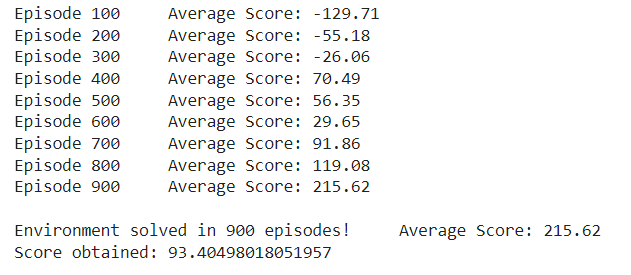

Reasons for DDQN is better than the Dueling DQN:

* Dueling DQN’s added complexity might lead to overfitting to specific training scenarios, reducing generalization.

* The way Q-values are combined in Dueling DQN might not perfectly capture the environment dynamics, leading to less accurate estimates.

* Differences in network initialization and inherent randomness in training could contribute to variability in performance, with Dueling DQN potentially performing worse in this specific run.


1. DQN: Took longer to converge but achieved slightly higher final performance.

2. DDQN: Converged faster and achieved higher final performance, demonstrating more efficient learning.

3. Dueling DQN: Improved learning stability and efficiency, with faster convergence but slightly lower final performance compared to DDQN.




![](https://i.imgur.com/QNCmfd3.gif)

